In [ ]:
 !pip install -q torchinfo

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [ ]:
# Get the going_modular scripts
print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 20.22 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data path

In [ ]:
import os
from pathlib import Path
import requests

# Setup path to data folder
data_path = Path("drive/MyDrive/Image_data")

# Train and Test Path

---



In [ ]:
# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

# **SqueezeNet Model**
This is the 1.0 version. Which is from the paper

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.SqueezeNet1_0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

SqueezeNet1_0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3df3c32330>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.squeezenet1_0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 17.6MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SqueezeNet (SqueezeNet)                       [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 512, 13, 13]    --                   True
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 96, 109, 109]   14,208               True
│    └─ReLU (1)                               [32, 96, 109, 109]   [32, 96, 109, 109]   --                   --
│    └─MaxPool2d (2)                          [32, 96, 109, 109]   [32, 96, 54, 54]     --                   --
│    └─Fire (3)                               [32, 96, 54, 54]     [32, 128, 54, 54]    --                   True
│    │    └─Conv2d (squeeze)                  [32, 96, 54, 54]     [32, 16, 54, 54]     1,552                True
│    │    └─ReLU (squeeze_activation)         [32, 16, 54, 54]     [32, 16, 54, 54]    

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False


In [ ]:
# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # Original SqueezeNet has dropout before the last conv layer
    nn.Conv2d(512, len(class_names), kernel_size=1), # Replace the original last conv layer
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(1) # Add AdaptiveAvgPool2d to flatten the output, only provide the positional argument for output_size
).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SqueezeNet (SqueezeNet)                       [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 512, 13, 13]    --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 96, 109, 109]   (14,208)             False
│    └─ReLU (1)                               [32, 96, 109, 109]   [32, 96, 109, 109]   --                   --
│    └─MaxPool2d (2)                          [32, 96, 109, 109]   [32, 96, 54, 54]     --                   --
│    └─Fire (3)                               [32, 96, 54, 54]     [32, 128, 54, 54]    --                   False
│    │    └─Conv2d (squeeze)                  [32, 96, 54, 54]     [32, 16, 54, 54]     (1,552)              False
│    │    └─ReLU (squeeze_activation)         [32, 16, 54, 54]     [32, 16, 54, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Add a random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0431 | train_acc: 0.6713 | test_loss: 0.3927 | test_acc: 0.9453
Epoch: 2 | train_loss: 0.2142 | train_acc: 0.9623 | test_loss: 0.1082 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1015 | train_acc: 0.9774 | test_loss: 0.0555 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0656 | train_acc: 0.9881 | test_loss: 0.0408 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0542 | train_acc: 0.9860 | test_loss: 0.0295 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0378 | train_acc: 0.9946 | test_loss: 0.0271 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0260 | train_acc: 0.9978 | test_loss: 0.0226 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0215 | train_acc: 0.9989 | test_loss: 0.0190 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0185 | train_acc: 0.9989 | test_loss: 0.0162 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0157 | train_acc: 1.0000 | test_loss: 0.0150 | test_acc: 1.0000


# **Creating Confusion**

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.2 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

['Apple', 'Banana', 'Bean', 'Onion', 'Potato']

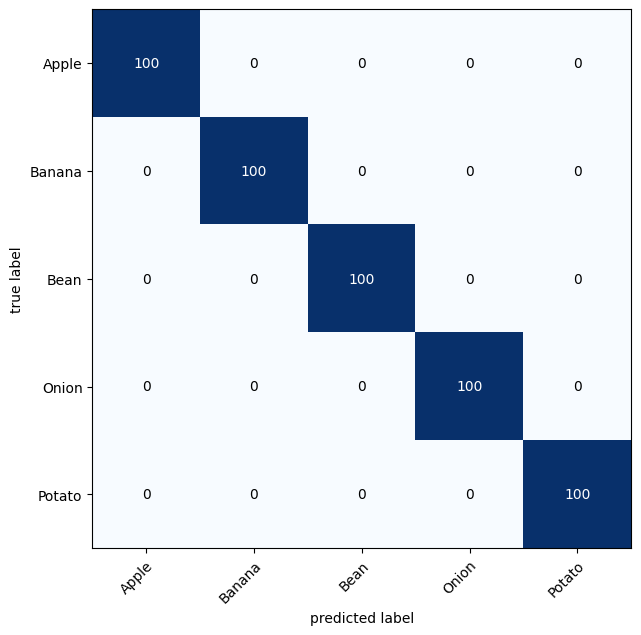

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

[INFO] Couldn't find helper_functions.py, downloading...


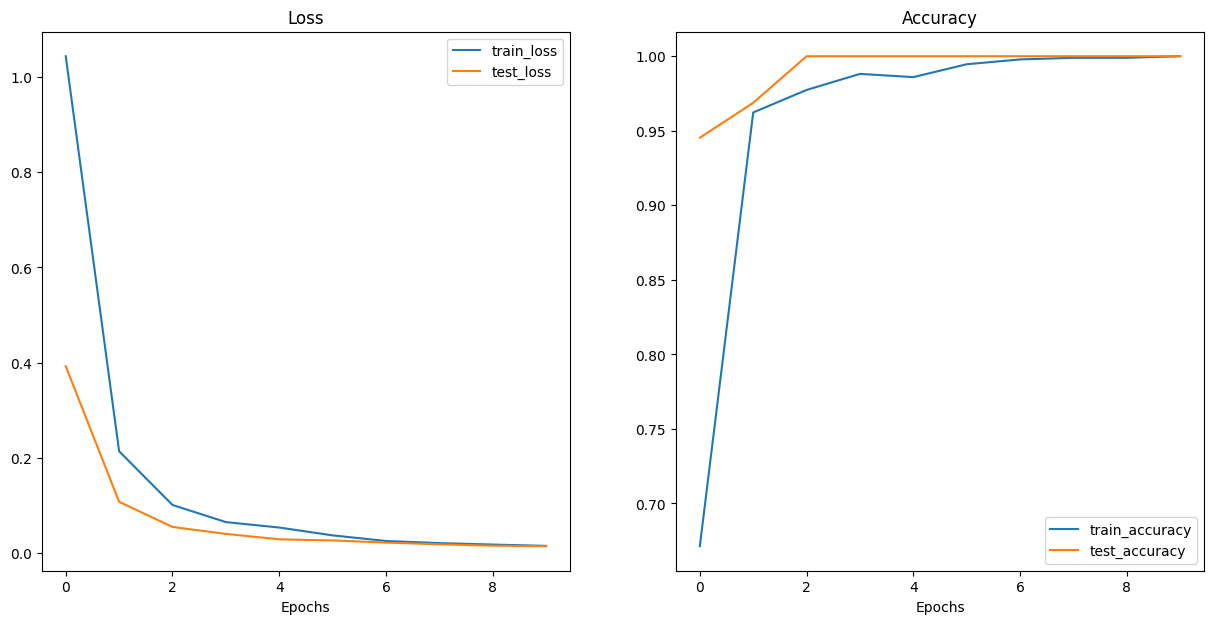

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

              precision    recall  f1-score   support

       Apple    1.00000   1.00000   1.00000        20
      Banana    1.00000   1.00000   1.00000        20
        Bean    1.00000   1.00000   1.00000        20
       Onion    1.00000   1.00000   1.00000        20
      Potato    1.00000   1.00000   1.00000        20

    accuracy                        1.00000       100
   macro avg    1.00000   1.00000   1.00000       100
weighted avg    1.00000   1.00000   1.00000       100



# **MobileNetV2**


---



---



---



In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.MobileNet_V2_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

MobileNet_V2_Weights.IMAGENET1K_V2

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3dc8f7fdd0>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.mobilenet_v2(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 80.6MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 112, 112]

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False


In [ ]:
# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=5, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.1154 | train_acc: 0.7985 | test_loss: 0.6906 | test_acc: 0.9297
Epoch: 2 | train_loss: 0.5384 | train_acc: 0.9601 | test_loss: 0.3837 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.3672 | train_acc: 0.9623 | test_loss: 0.2829 | test_acc: 0.9453
Epoch: 4 | train_loss: 0.2478 | train_acc: 0.9774 | test_loss: 0.2069 | test_acc: 0.9453
Epoch: 5 | train_loss: 0.2062 | train_acc: 0.9774 | test_loss: 0.1811 | test_acc: 0.9531
Epoch: 6 | train_loss: 0.1775 | train_acc: 0.9795 | test_loss: 0.1515 | test_acc: 0.9531
Epoch: 7 | train_loss: 0.1369 | train_acc: 0.9774 | test_loss: 0.1280 | test_acc: 0.9531
Epoch: 8 | train_loss: 0.1273 | train_acc: 0.9849 | test_loss: 0.1118 | test_acc: 0.9766
Epoch: 9 | train_loss: 0.1224 | train_acc: 0.9806 | test_loss: 0.1027 | test_acc: 0.9766
Epoch: 10 | train_loss: 0.1014 | train_acc: 0.9935 | test_loss: 0.0901 | test_acc: 0.9766


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

['Apple', 'Banana', 'Bean', 'Onion', 'Potato']

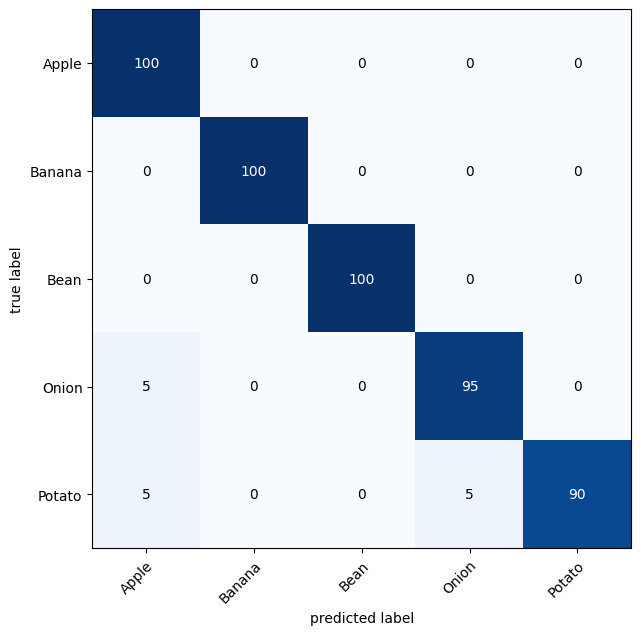

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

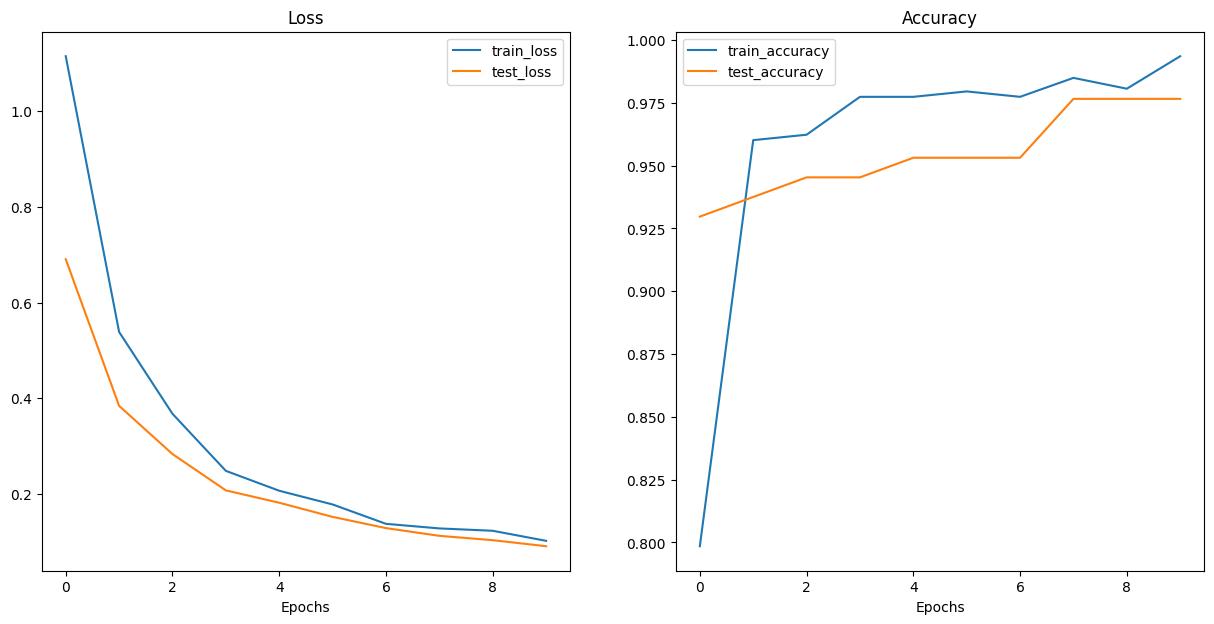

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

              precision    recall  f1-score   support

       Apple    0.90909   1.00000   0.95238        20
      Banana    1.00000   1.00000   1.00000        20
        Bean    1.00000   1.00000   1.00000        20
       Onion    0.95000   0.95000   0.95000        20
      Potato    1.00000   0.90000   0.94737        20

    accuracy                        0.97000       100
   macro avg    0.97182   0.97000   0.96995       100
weighted avg    0.97182   0.97000   0.96995       100



# **ShuffleNet_V2_0.5**

---



---



---
0.5x version using


In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.ShuffleNet_V2_X0_5_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3dc8c65a30>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.shufflenet_v2_x0_5(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


100%|██████████| 5.28M/5.28M [00:00<00:00, 22.4MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ShuffleNetV2 (ShuffleNetV2)              [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (conv1)                     [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    └─BatchNorm2d (1)                   [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    └─ReLU (2)                          [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 24, 112, 112]   [32, 24, 56, 56]     --                   --
├─Sequential (stage2)                    [32, 24, 56, 56]     [32, 48, 28, 28]     --                   True
│    └─InvertedResidual (0)              [32, 24, 56, 56]     [32, 48, 28, 28]     --                   True
│    │    └─Sequen

In [ ]:
# Freeze all base layers except the final classifier
for name, param in model.named_parameters():
    if 'fc' not in name: # Assuming the final fully connected layer is named 'fc'
        param.requires_grad = False

In [ ]:
# Recreate the classifier layer and seed it to the target device
# The in_features for ShuffleNet_V2_X0_5's classifier is 1024
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024, # Corrected in_features for ShuffleNet_V2_X0_5
                    out_features=len(class_names), # Set the output features to number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ShuffleNetV2 (ShuffleNetV2)              [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (conv1)                     [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    └─BatchNorm2d (1)                   [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    └─ReLU (2)                          [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 24, 112, 112]   [32, 24, 56, 56]     --                   --
├─Sequential (stage2)                    [32, 24, 56, 56]     [32, 48, 28, 28]     --                   False
│    └─InvertedResidual (0)              [32, 24, 56, 56]     [32, 48, 28, 28]     --                   False
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.5577 | train_acc: 0.6315 | test_loss: 1.4935 | test_acc: 0.9062
Epoch: 2 | train_loss: 1.4491 | train_acc: 0.8481 | test_loss: 1.3883 | test_acc: 0.8906
Epoch: 3 | train_loss: 1.3476 | train_acc: 0.9504 | test_loss: 1.3036 | test_acc: 0.9531
Epoch: 4 | train_loss: 1.2526 | train_acc: 0.9569 | test_loss: 1.2128 | test_acc: 0.9297
Epoch: 5 | train_loss: 1.1762 | train_acc: 0.9461 | test_loss: 1.1362 | test_acc: 0.9375
Epoch: 6 | train_loss: 1.0925 | train_acc: 0.9666 | test_loss: 1.0652 | test_acc: 0.9453
Epoch: 7 | train_loss: 1.0287 | train_acc: 0.9644 | test_loss: 0.9950 | test_acc: 0.9375
Epoch: 8 | train_loss: 0.9541 | train_acc: 0.9644 | test_loss: 0.9234 | test_acc: 0.9297
Epoch: 9 | train_loss: 0.8961 | train_acc: 0.9655 | test_loss: 0.8705 | test_acc: 0.9297
Epoch: 10 | train_loss: 0.8458 | train_acc: 0.9558 | test_loss: 0.8144 | test_acc: 0.9297


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

['Apple', 'Banana', 'Bean', 'Onion', 'Potato']

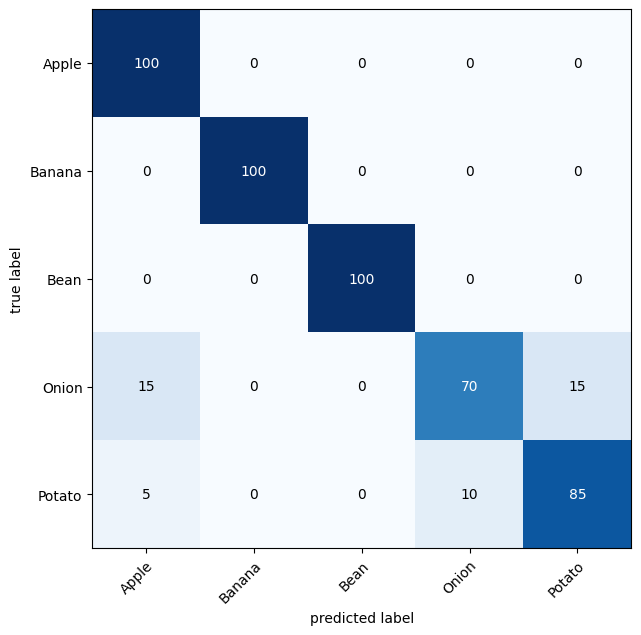

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

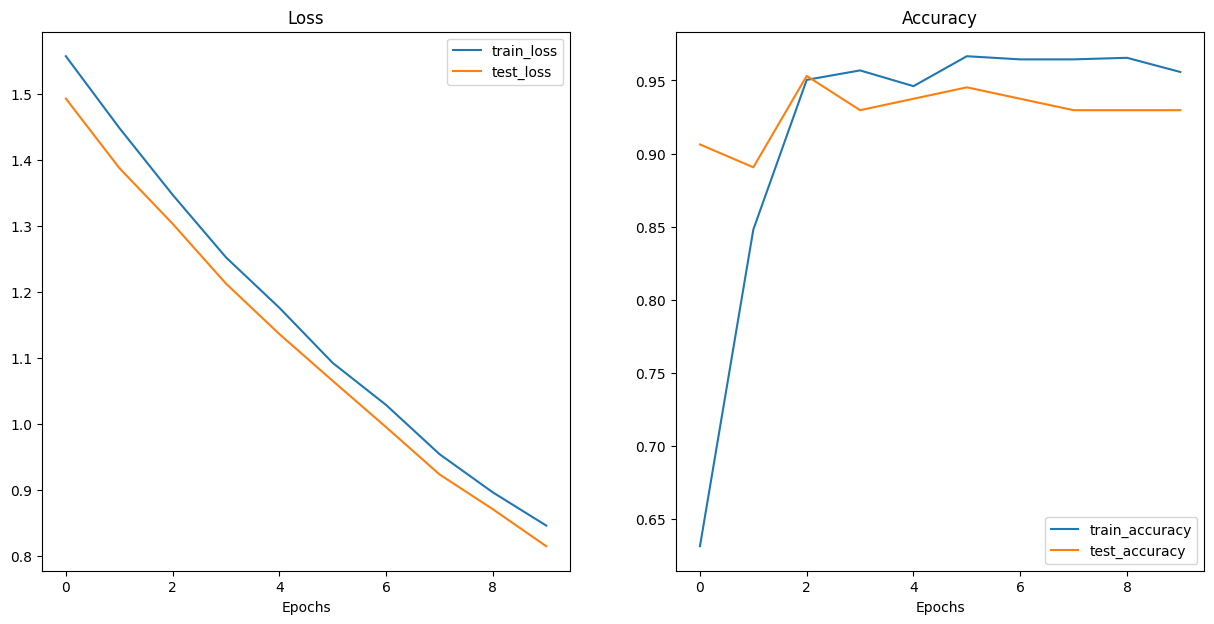

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=4))

              precision    recall  f1-score   support

       Apple     0.8333    1.0000    0.9091        20
      Banana     1.0000    1.0000    1.0000        20
        Bean     1.0000    1.0000    1.0000        20
       Onion     0.8750    0.7000    0.7778        20
      Potato     0.8500    0.8500    0.8500        20

    accuracy                         0.9100       100
   macro avg     0.9117    0.9100    0.9074       100
weighted avg     0.9117    0.9100    0.9074       100



# **ResNet18**

---



---



---



In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet18_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3dc47f7710>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.resnet18(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
# Freeze all base layers except the final classifier
for name, param in model.named_parameters():
    if 'fc' not in name: # Assuming the final fully connected layer is named 'fc'
        param.requires_grad = False

In [ ]:
# Recreate the classifier layer and seed it to the target device
# The in_features for ResNet18's classifier is 512
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=512, # Corrected in_features for ResNet18
                    out_features=5, # Set the output features to number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.1557 | train_acc: 0.6078 | test_loss: 0.6440 | test_acc: 0.9375
Epoch: 2 | train_loss: 0.4837 | train_acc: 0.9246 | test_loss: 0.3257 | test_acc: 0.9453
Epoch: 3 | train_loss: 0.2885 | train_acc: 0.9655 | test_loss: 0.2703 | test_acc: 0.9453
Epoch: 4 | train_loss: 0.2611 | train_acc: 0.9418 | test_loss: 0.2180 | test_acc: 0.9453
Epoch: 5 | train_loss: 0.2017 | train_acc: 0.9612 | test_loss: 0.1826 | test_acc: 0.9453
Epoch: 6 | train_loss: 0.1515 | train_acc: 0.9817 | test_loss: 0.1429 | test_acc: 0.9531
Epoch: 7 | train_loss: 0.1395 | train_acc: 0.9806 | test_loss: 0.1413 | test_acc: 0.9531
Epoch: 8 | train_loss: 0.1214 | train_acc: 0.9838 | test_loss: 0.1270 | test_acc: 0.9531
Epoch: 9 | train_loss: 0.1077 | train_acc: 0.9795 | test_loss: 0.1232 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.0953 | train_acc: 0.9849 | test_loss: 0.1135 | test_acc: 0.9688


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

['Apple', 'Banana', 'Bean', 'Onion', 'Potato']

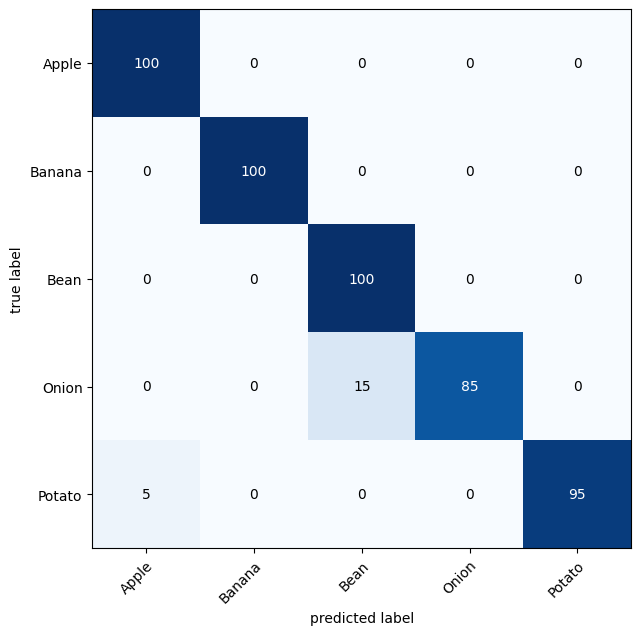

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

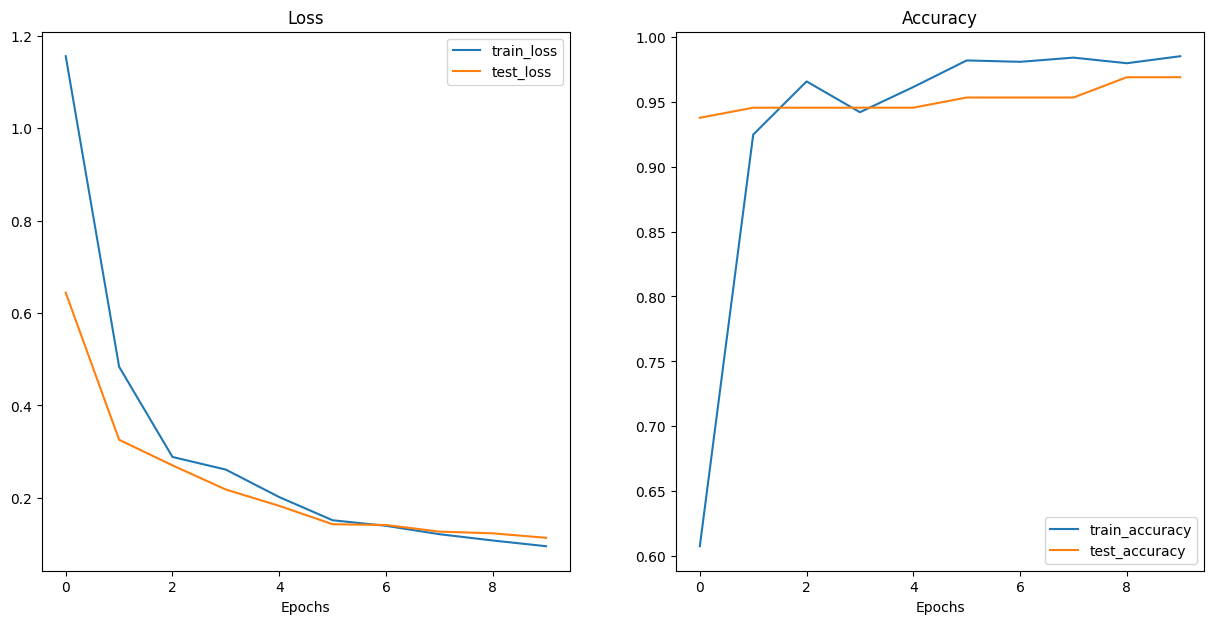

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

              precision    recall  f1-score   support

       Apple    0.95238   1.00000   0.97561        20
      Banana    1.00000   1.00000   1.00000        20
        Bean    0.86957   1.00000   0.93023        20
       Onion    1.00000   0.85000   0.91892        20
      Potato    1.00000   0.95000   0.97436        20

    accuracy                        0.96000       100
   macro avg    0.96439   0.96000   0.95982       100
weighted avg    0.96439   0.96000   0.95982       100



# **Efficient Net**

---



---



---



In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3dc1ac01a0>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 63.9MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False


In [ ]:
# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=5, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0256 | train_acc: 0.7435 | test_loss: 0.5113 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.4180 | train_acc: 0.9558 | test_loss: 0.2694 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.2395 | train_acc: 0.9784 | test_loss: 0.1806 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.1878 | train_acc: 0.9817 | test_loss: 0.1522 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.1390 | train_acc: 0.9860 | test_loss: 0.1119 | test_acc: 0.9844
Epoch: 6 | train_loss: 0.1253 | train_acc: 0.9871 | test_loss: 0.1126 | test_acc: 0.9844
Epoch: 7 | train_loss: 0.1040 | train_acc: 0.9892 | test_loss: 0.0847 | test_acc: 0.9922
Epoch: 8 | train_loss: 0.0997 | train_acc: 0.9892 | test_loss: 0.0697 | test_acc: 0.9922
Epoch: 9 | train_loss: 0.0953 | train_acc: 0.9795 | test_loss: 0.0611 | test_acc: 0.9922
Epoch: 10 | train_loss: 0.0713 | train_acc: 0.9935 | test_loss: 0.0627 | test_acc: 0.9922


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

['Apple', 'Banana', 'Bean', 'Onion', 'Potato']

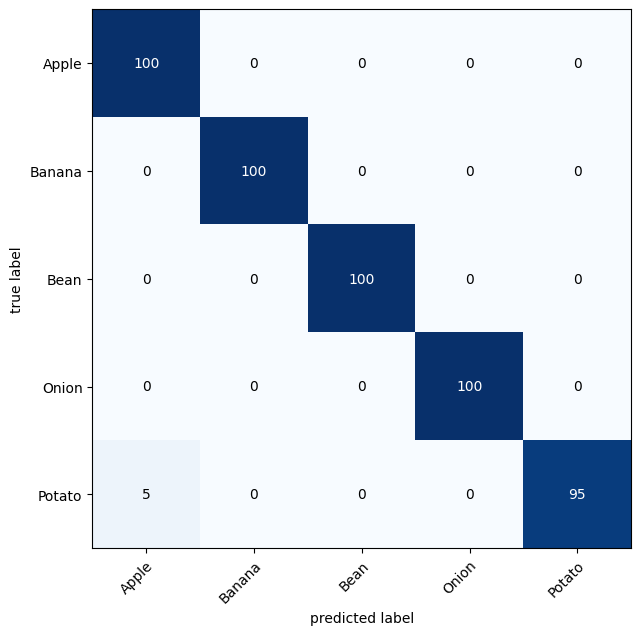

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

              precision    recall  f1-score   support

       Apple    0.95238   1.00000   0.97561        20
      Banana    1.00000   1.00000   1.00000        20
        Bean    1.00000   1.00000   1.00000        20
       Onion    1.00000   1.00000   1.00000        20
      Potato    1.00000   0.95000   0.97436        20

    accuracy                        0.99000       100
   macro avg    0.99048   0.99000   0.98999       100
weighted avg    0.99048   0.99000   0.98999       100



# **googlenet**


---



---



---



In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.GoogLeNet_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

GoogLeNet_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3dc1862600>,
 ['Apple', 'Banana', 'Beans', 'Onion', 'Potato'])

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.googlenet(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 139MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─BasicConv2d (conv1)                    [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (bn)                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─MaxPool2d (maxpool1)                   [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─Conv2d (conv)                     [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     128                  True
├─BasicConv2d (c

In [ ]:
# Freeze all base layers except the final classifier
for name, param in model.named_parameters():
    if 'fc' not in name: # Assuming the final fully connected layer is named 'fc'
        param.requires_grad = False


In [ ]:
# Recreate the classifier layer and seed it to the target device
# The in_features for GoogLeNet's classifier is 1024
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024, # Corrected in_features for GoogLeNet
                    out_features=5, # Set the output features to number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 224, 224]    [32, 5]              --                   Partial
├─BasicConv2d (conv1)                    [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn)                  [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─MaxPool2d (maxpool1)                   [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─Conv2d (conv)                     [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     (128)                False
├─Basic

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.1549 | train_acc: 0.6724 | test_loss: 0.7370 | test_acc: 0.9297
Epoch: 2 | train_loss: 0.5757 | train_acc: 0.9332 | test_loss: 0.4256 | test_acc: 0.9219
Epoch: 3 | train_loss: 0.3904 | train_acc: 0.9504 | test_loss: 0.3130 | test_acc: 0.9609
Epoch: 4 | train_loss: 0.3180 | train_acc: 0.9429 | test_loss: 0.2574 | test_acc: 0.9609
Epoch: 5 | train_loss: 0.2568 | train_acc: 0.9547 | test_loss: 0.1892 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.2072 | train_acc: 0.9774 | test_loss: 0.1647 | test_acc: 0.9766
Epoch: 7 | train_loss: 0.2076 | train_acc: 0.9569 | test_loss: 0.1509 | test_acc: 0.9766
Epoch: 8 | train_loss: 0.1647 | train_acc: 0.9741 | test_loss: 0.1379 | test_acc: 0.9766
Epoch: 9 | train_loss: 0.1503 | train_acc: 0.9752 | test_loss: 0.1018 | test_acc: 0.9844
Epoch: 10 | train_loss: 0.1552 | train_acc: 0.9709 | test_loss: 0.1186 | test_acc: 0.9688


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

# **MNASNet**


---



---



---



In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.MNASNet0_5_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

In [ ]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.mnasnet0_5(weights=weights).to(device)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Freeze all base layers except the final classifier
for name, param in model.named_parameters():
    if 'fc' not in name: # Assuming the final fully connected layer is named 'fc'
        param.requires_grad = False


In [ ]:
# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=5, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MNASNet (MNASNet)                             [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (layers)                         [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    └─BatchNorm2d (1)                        [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    └─ReLU (2)                               [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─Conv2d (3)                             [32, 16, 112, 112]   [32, 16, 112, 112]   (144)                False
│    └─BatchNorm2d (4)                        [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    └─ReLU (5)                               [32, 16, 112, 112]   [32, 16, 1

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.4372 | train_acc: 0.8017 | test_loss: 1.3538 | test_acc: 0.8828
Epoch: 2 | train_loss: 1.1350 | train_acc: 0.9429 | test_loss: 1.1539 | test_acc: 0.9219
Epoch: 3 | train_loss: 0.9307 | train_acc: 0.9407 | test_loss: 0.9976 | test_acc: 0.9219
Epoch: 4 | train_loss: 0.7558 | train_acc: 0.9655 | test_loss: 0.8772 | test_acc: 0.9141
Epoch: 5 | train_loss: 0.6409 | train_acc: 0.9494 | test_loss: 0.7842 | test_acc: 0.9219
Epoch: 6 | train_loss: 0.5453 | train_acc: 0.9688 | test_loss: 0.7102 | test_acc: 0.9219
Epoch: 7 | train_loss: 0.4738 | train_acc: 0.9612 | test_loss: 0.6464 | test_acc: 0.9219
Epoch: 8 | train_loss: 0.4206 | train_acc: 0.9709 | test_loss: 0.5953 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.3781 | train_acc: 0.9698 | test_loss: 0.5549 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.3347 | train_acc: 0.9741 | test_loss: 0.5185 | test_acc: 0.9375


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.extend(y_pred.cpu().tolist())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.tensor(y_preds, device = device)

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

In [ ]:
class_names = test_data.classes
class_names

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor.to(confmat.device),
                         target=torch.tensor(test_data.targets).to(confmat.device))

confmat_normalized = confmat_tensor / confmat_tensor.sum(axis=1, keepdims=True) * 100
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_normalized.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
);

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(torch.tensor(test_data.targets).cpu(), torch.tensor(y_preds).cpu(), target_names=class_names, digits=5))

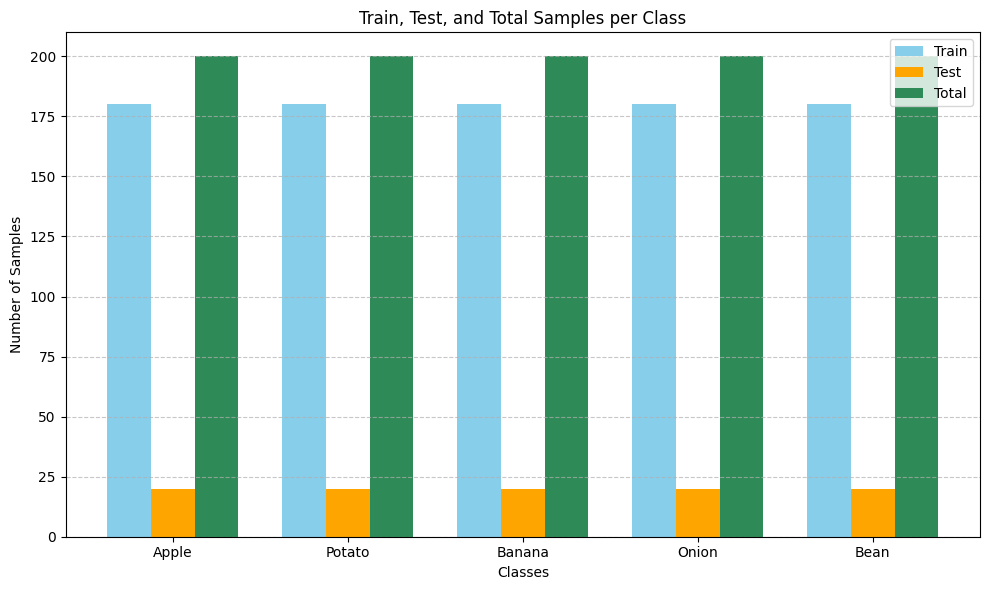

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names and sample counts
classes = ['Apple', 'Potato', 'Banana', 'Onion','Bean']
train_samples = [180, 180, 180, 180, 180]
test_samples = [20, 20, 20, 20, 20]
total_samples = [t + v for t, v in zip(train_samples, test_samples)]

# Bar width and positions
x = np.arange(len(classes))  # Label locations
bar_width = 0.25

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, train_samples, width=bar_width, label='Train', color='skyblue')
plt.bar(x, test_samples, width=bar_width, label='Test', color='orange')
plt.bar(x + bar_width, total_samples, width=bar_width, label='Total', color='seagreen')

# Labels and formatting
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Train, Test, and Total Samples per Class')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
